Time Series Analysis for Dynamical Systems


# 1. Problem Definition: Short Term Load Forecasting

Load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures.


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [16]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.47 s (started: 2024-09-13 13:00:24 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [17]:
#Local Installations
!pip install statsmodels

time: 1.45 s (started: 2024-09-13 13:00:25 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 0 ns (started: 2024-09-13 13:00:27 +02:00)


In [19]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 0 ns (started: 2024-09-13 13:00:27 +02:00)


In [20]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 0 ns (started: 2024-09-13 13:00:27 +02:00)


# 3. Pre-processing


In [23]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 13:00:46 +02:00)


In [24]:
data = read_Data()

time: 32 ms (started: 2024-09-13 13:00:47 +02:00)


In [25]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 171 ms (started: 2024-09-13 13:00:50 +02:00)


# SARIMAX - Recursive Multi-step Forecasting

 In this approach, a single model is trained to make one-step-ahead predictions, and its outputs are fed back as inputs to forecast multiple steps into the future. For example, if you want to predict three future time steps, you would use the same model to predict the first step, then use that prediction as input to predict the second step, and so on. This method can be computationally efficient but may accumulate errors from each prediction.

### Implementing the Model


In [26]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
# trainin data: filtered copy
train = data.copy()[(data.index >= train_start_dt)& (data.index < test_start_dt)][['load']]
# test data: filtered copy
test = data.copy()[(data.index >= test_start_dt) & (data.index < test_end_dt)][['load']]
#let's see how it looks like:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (18984, 1)
Test data shape:  (72, 1)
time: 0 ns (started: 2024-09-13 13:00:53 +02:00)


In [23]:
#Rescaling the data [0,1]
scaler = pp.MinMaxScaler()
train['load'] = scaler.fit_transform(train)
test['load'] = scaler.transform(test)

time: 0 ns (started: 2024-09-13 12:15:48 +02:00)


In [24]:
#-----------------------------------------------------------
#Hyperparameters
#-----------------------------------------------------------
horizon = 6
#The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
# d must be an integer indicating the integration order of the process, while p and q may either 
# be an integers indicating the AR and MA orders (so that all lags up to those orders are included)
# or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
order = (3, 1, 6)
#The (P,D,Q,s) order of the seasonal component of the model for:
# the AR parameters,  differences, MA parameters, and periodicity.
seasonal_order = (1, 1, 1, 24) # 24 is the daily seasonality order

time: 0 ns (started: 2024-09-13 12:15:48 +02:00)


In [25]:
#Model implementation
#here endog is the observed time-series process y:
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)

time: 16 ms (started: 2024-09-13 12:15:48 +02:00)


c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [26]:
#Copying the test DF:
test_shifted = test.copy()
#preparing the shifted test data:
for t in range(1, horizon):
  test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
test_shifted = test_shifted.dropna()
test_shifted

,load,load+1,load+2,load+3,load+4,load+5
2014-11-01 00:00:00,0.223112,0.164869,0.140216,0.126656,0.124191,0.135593
2014-11-01 01:00:00,0.164869,0.140216,0.126656,0.124191,0.135593,0.166718
2014-11-01 02:00:00,0.140216,0.126656,0.124191,0.135593,0.166718,0.226502
2014-11-01 03:00:00,0.126656,0.124191,0.135593,0.166718,0.226502,0.305393
2014-11-01 04:00:00,0.124191,0.135593,0.166718,0.226502,0.305393,0.372881
...,...,...,...,...,...,...
2014-11-03 14:00:00,0.430817,0.427427,0.448382,0.502311,0.585824,0.575655
2014-11-03 15:00:00,0.427427,0.448382,0.502311,0.585824,0.575655,0.539599
2014-11-03 16:00:00,0.448382,0.502311,0.585824,0.575655,0.539599,0.490601
2014-11-03 17:00:00,0.502311,0.585824,0.575655,0.539599,0.490601,0.396302


time: 16 ms (started: 2024-09-13 12:15:48 +02:00)


In [27]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 0 ns (started: 2024-09-13 12:15:48 +02:00)


In [28]:
# Predictions on test data:
training_window = 720 # Here we are using a very small portion of the past,
# I think we made like this so that the trining is not too computationaly expensive
train_ts = train['load']
test_ts = test_shifted
#Creating the history
history = [x for x in train_ts]
#Filtering the training window: Uncomment the below line if you want.
history = history[(-training_window):]
#Creating predictions to store the model outcomes:
predictions = list()
#Calling model: 
#Horizon calculation list:
for t in range(0,test_ts.shape[0],horizon):
  model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
  #Model fitting:
  model_fit = model.fit()
  #Model predictions:
  y_p = model_fit.forecast(steps = horizon) # its like model predict in scikit learn
  obs = list(test_ts.iloc[t])
# moving the training window: here I add the prediction as in real life we would 
# not know the true value! Here we will also save the predictions.
  for j in range(horizon):
    predictions.append(y_p[j])
    history.append(y_p[j])
  #Dropping the first horizon elements:
  for j in range(horizon):
    history.pop(0)
  print(test_ts.index[t])
  print(t+1, ': predicted =', y_p, 'true value =', obs)

2014-11-01 00:00:00
1 : predicted = [0.20396937 0.1586907  0.1224784  0.1007945  0.10024499 0.12661711] true value = [0.22311248073959933, 0.16486902927580893, 0.1402157164869029, 0.12665639445300458, 0.12419106317411399, 0.13559322033898302]
2014-11-01 06:00:00
7 : predicted = [0.20381291 0.33660985 0.40871839 0.42752047 0.43690674 0.43673583] true value = [0.1667180277349769, 0.22650231124807396, 0.30539291217257314, 0.3728813559322034, 0.42434514637904464, 0.4489984591679508]
2014-11-01 12:00:00
13 : predicted = [0.42948558 0.41697011 0.40994855 0.39586381 0.39448041 0.41258219] true value = [0.4576271186440677, 0.4499229583975346, 0.44006163328197223, 0.4345146379044684, 0.43852080123266557, 0.4656394453004622]
2014-11-01 18:00:00
19 : predicted = [0.44892143 0.48024573 0.45635781 0.41895429 0.34988961 0.26254473] true value = [0.5044684129429893, 0.5109399075500771, 0.46995377503852076, 0.43050847457627106, 0.3679506933744222, 0.2933744221879815]
2014-11-02 00:00:00
25 : predicted

In [29]:
# Evaluation of results:
# We will combine the predictions with the actual load values in a DF. 
eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
#Updating the indices:
eval_df=(eval_df.set_index(test.index)) #
#Adding true values:
eval_df['actual'] = test['load']
#Let's check:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-11-01 00:00:00 to 2014-11-03 23:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 16 ms (started: 2024-09-13 12:27:17 +02:00)


In [30]:
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

time: 0 ns (started: 2024-09-13 12:27:17 +02:00)


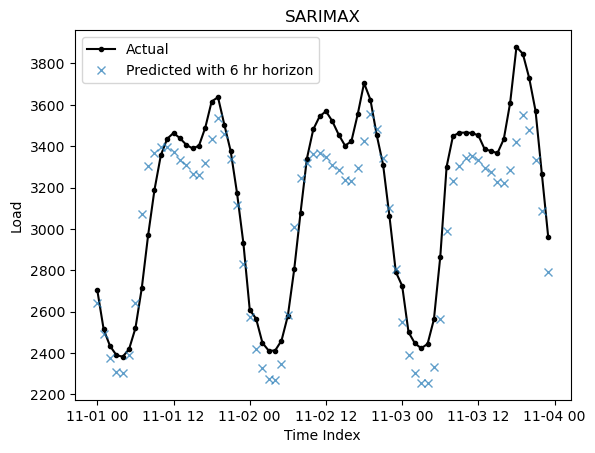

time: 219 ms (started: 2024-09-13 12:27:17 +02:00)


In [31]:
#Plotting predictions: 
plt.figure();
plt.plot(eval_df['actual'], 'k.-');
plt.plot(eval_df['prediction'], 'x', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[69:138], 'o', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[-69:], '+', alpha=0.70);
plt.legend(['Actual',
            ('Predicted with ' + str (horizon) + ' hr horizon')])
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SARIMAX');


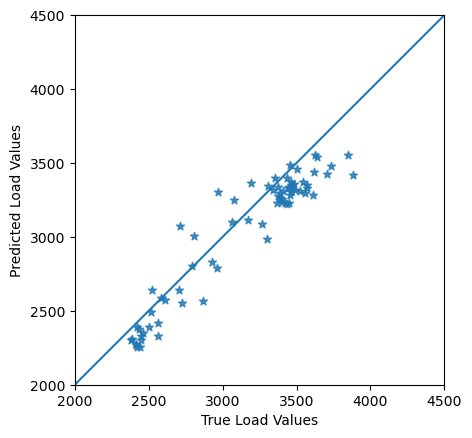

time: 94 ms (started: 2024-09-13 12:27:17 +02:00)


In [32]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
a = plt.axes(aspect='equal')
plt.scatter(eval_df['actual'], eval_df['prediction'],marker='*',alpha=0.80)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[69:138],marker='o',alpha=0.60)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[138:207],marker='+',alpha=0.50)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Load Values')
lims = [2000, 4500]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

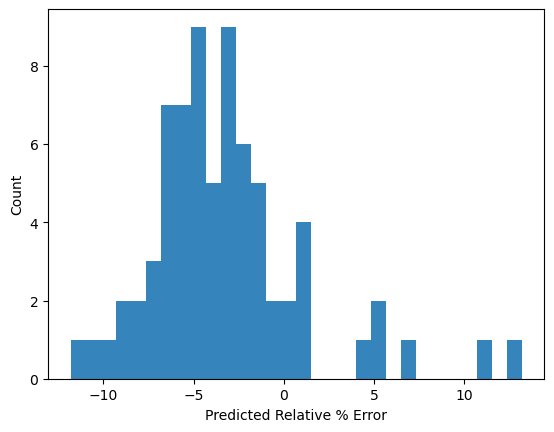

time: 125 ms (started: 2024-09-13 12:27:17 +02:00)


In [33]:
# Calculating the error variations:
error_nn1 = (eval_df['prediction'] - eval_df['actual'])/eval_df['actual']*100

plt.hist(error_nn1, bins=30,alpha=0.9)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [34]:
#Calculating R^2: r2_score(y_true, y_pred)
Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

R^2 score is  0.85
time: 0 ns (started: 2024-09-13 12:27:17 +02:00)
